# Amazon SageMaker Autopilot

This notebook provides an overview of how to use Amazon SageMaker Autopilot.  Amazon SageMaker Autopilot automatically trains and tunes the best machine learning models for classification or regression, based on your data while allowing to maintain full control and visibility. 

For this example we'll use a tabular dataset for classification.  This dataset containes observations from the Roosevelt National Forest in Colorado.  Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types). 

The classification task is - given attributes of the land, can you predict the forest cover type?



## Overview
Import Python libraries and set up SageMaker.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import boto3
import sagemaker

In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'autopilot_demo_cover'
region = boto3.Session().region_name
#role = sagemaker.get_execution_role()
role = 'arn:aws:iam::431615879134:role/sagemaker-test-role'
sm = boto3.Session().client(service_name='sagemaker',region_name=region)
sm_rt = boto3.Session().client('runtime.sagemaker', region_name=region)

# Data


## Read and Explore Data

In [6]:
df = pd.read_csv('/root/ap/data/covtype.csv')

In [7]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

Text(0, 0.5, 'Relative Frequency')

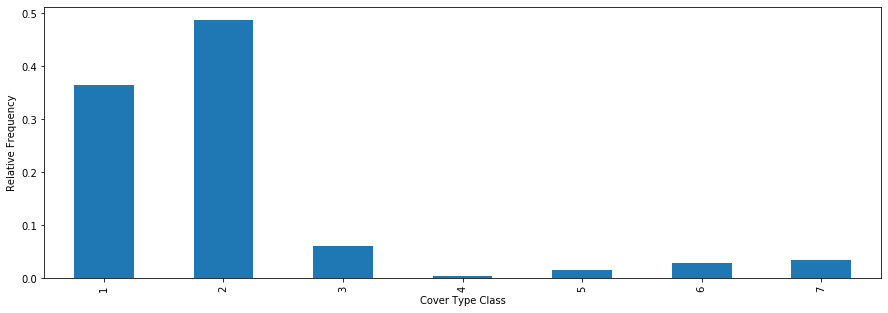

In [8]:
df['Cover_Type'].value_counts(normalize=True,sort=False).plot(kind='bar',figsize=(15,5))
plt.xlabel('Cover Type Class')
plt.ylabel('Relative Frequency')

# Autopilot

In [16]:
# keep a bit of data for testing...
np.random.seed(1234)
train_data, test_data, _ = np.split(df.sample(frac=1, random_state=1234),[int(0.95 * len(df)),int(len(df))])

# Save to CSV files
train_data.to_csv('/root/ap/data/automl-train.csv', index=False, header=True, sep=',') # Need to keep column names
test_data.to_csv('/root/ap/data/automl-test.csv', index=False, header=True, sep=',')

In [10]:
# csv's must be comma sep
sess.upload_data(path="/root/ap/data/automl-train.csv", key_prefix=prefix+"/input")

's3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/input/automl-train.csv'

to set up the autopilot job we need the following:

* dataset in s3
* name of the target variable
* IAM role


In [13]:
job_config = {
    'CompletionCriteria': {
      'MaxRuntimePerTrainingJobInSeconds': 600,  # a single canidate job duration 
      # 'MaxCandidates': 10,
      'MaxAutoMLJobRuntimeInSeconds': 3600  # one hour limit for the entire job
    },
}

input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/input'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'Cover_Type'  # the column we want to predict
    }
]

output_data_config = { 'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix) }

# Optional parameters
problem_type = 'MulticlassClassification'
job_objective = { 'MetricName': 'F1macro' }

In [14]:
from time import gmtime, strftime, sleep
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

auto_ml_job_name = 'automl-covertype-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig=job_config,
                      AutoMLJobObjective=job_objective,
                      ProblemType=problem_type,
                      RoleArn=role)

AutoMLJobName: automl-covertype-26-18-52-53


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:626825435328:automl-job/automl-covertype-26-18-52-53',
 'ResponseMetadata': {'RequestId': 'ec20594a-d65e-45ea-9b06-3ebcd5f199fb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ec20594a-d65e-45ea-9b06-3ebcd5f199fb',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '99',
   'date': 'Sat, 26 Sep 2020 18:52:55 GMT'},
  'RetryAttempts': 0}}

## Tracking the progress of the Amazon SageMaker AutoPilot job

SageMaker AutoPilot job consists of four high-level steps : 
* Data Preprocessing, where the dataset is split into train and validation sets.
* Recommending Pipelines, where the dataset is analyzed and SageMaker AutoPilot comes up with a list of ML pipelines that should be tried out on the dataset.
* Automatic Feature Engineering, where SageMaker AutoPilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* ML pipeline selection and hyperparameter tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline). 

As you can guess, several of these steps are powered by **Amazon SageMaker Processing**.

In [21]:
 %%time
job_run_status = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['AutoMLJobStatus']

print(job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(60)

Completed
CPU times: user 15.7 ms, sys: 3 µs, total: 15.7 ms
Wall time: 91.9 ms


## Fetch the auto-generated notebooks

(you can stop the above cell once Analyzing dat
Once the 'AnalyzingData' step is complete, SageMaker AutoPilot generates two notebooks: 
* Data exploration
* Candidate definition.

In [22]:
job = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_candidate_notebook = job['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation']
job_data_notebook = job['AutoMLJobArtifacts']['DataExplorationNotebookLocation']

print(job_candidate_notebook)
print(job_data_notebook)

s3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/output/automl-covertype-26-18-52-53/sagemaker-automl-candidates/pr-1-72e2ab6624db4265a1ebdb5e38a041634ed11cfa49204b44a14582ced1/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb
s3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/output/automl-covertype-26-18-52-53/sagemaker-automl-candidates/pr-1-72e2ab6624db4265a1ebdb5e38a041634ed11cfa49204b44a14582ced1/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb


In [23]:
# %%sh -s $job_candidate_notebook $job_data_notebook
!aws s3 cp {job_candidate_notebook} /root/ap/
!aws s3 cp {job_data_notebook} /root/ap/

download: s3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/output/automl-covertype-26-18-52-53/sagemaker-automl-candidates/pr-1-72e2ab6624db4265a1ebdb5e38a041634ed11cfa49204b44a14582ced1/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb to ap/SageMakerAutopilotCandidateDefinitionNotebook.ipynb
download: s3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/output/automl-covertype-26-18-52-53/sagemaker-automl-candidates/pr-1-72e2ab6624db4265a1ebdb5e38a041634ed11cfa49204b44a14582ced1/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb to ap/SageMakerAutopilotDataExplorationNotebook.ipynb


Lets go look at these notebooks that were autogenerated for us

## Inspecting the SageMaker Autopilot job with Amazon SageMaker Experiments
Once the 'ModelTuning' step starts, we can use the SageMaker Experiments SDK to list and view all jobs. Data is stored in a pandas dataframe, which makes it easy to filter it, compare it to other experiments, etc.

In [24]:
from sagemaker.analytics import ExperimentAnalytics

analytics = ExperimentAnalytics(
    sagemaker_session=sess, 
    experiment_name=auto_ml_job_name+'-aws-auto-ml-job'
)

df = analytics.dataframe()
df

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,_tuning_objective_metric,alpha,colsample_bytree,...,code - MediaType,code - Value,input_channel_mode,job_name,label_col,max_dataset_size,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,ds - MediaType,ds - Value
0,tuning-job-1-e08c960e01984b4492-056-ef5e6a61-a...,tuning-job-1-e08c960e01984b4492-056-ef5e6a61-a...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,0.004397,0.383481,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tuning-job-1-e08c960e01984b4492-062-a481d3aa-a...,tuning-job-1-e08c960e01984b4492-062-a481d3aa-a...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,0.003573,0.815086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tuning-job-1-e08c960e01984b4492-052-3ab9cfdc-a...,tuning-job-1-e08c960e01984b4492-052-3ab9cfdc-a...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,0.000017,0.753552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tuning-job-1-e08c960e01984b4492-050-bf4a1ede-a...,tuning-job-1-e08c960e01984b4492-050-bf4a1ede-a...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,1.354001,0.319729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tuning-job-1-e08c960e01984b4492-049-6a12120e-a...,tuning-job-1-e08c960e01984b4492-049-6a12120e-a...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,validation:f1,0.000005,0.750449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,automl-cov-dpp7-1-6da5e6d1edd8414b88605823884f...,automl-cov-dpp7-1-6da5e6d1edd8414b88605823884f...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,NaN,NaN,NaN,...,application/x-code,s3://sagemaker-us-east-1-626825435328/autopilo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,automl-cov-dpp5-1-ce77a54edfb646408e71a96aa425...,automl-cov-dpp5-1-ce77a54edfb646408e71a96aa425...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,NaN,NaN,NaN,...,application/x-code,s3://sagemaker-us-east-1-626825435328/autopilo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,automl-cov-dpp2-1-156edf68dd7247348b75141035b1...,automl-cov-dpp2-1-156edf68dd7247348b75141035b1...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,NaN,NaN,NaN,...,application/x-code,s3://sagemaker-us-east-1-626825435328/autopilo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,automl-cov-dpp9-1-d6acbb9699764e98b27cba18501a...,automl-cov-dpp9-1-d6acbb9699764e98b27cba18501a...,arn:aws:sagemaker:us-east-1:626825435328:train...,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,1.0,ml.m5.4xlarge,50.0,NaN,NaN,NaN,...,application/x-code,s3://sagemaker-us-east-1-626825435328/autopilo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Listing all candidates explored by Amazon SageMaker AutoPilot
Once the 'ModelTuning' step is complete, we can list top candidates that were identified by SageMaker AutoPilot, and sort them by their final performance metric.

In [25]:
candidates = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name, 
                                                SortBy='FinalObjectiveMetricValue')['Candidates']
index = 1
for candidate in candidates:
  print (str(index) + "  " 
         + candidate['CandidateName'] + "  " 
         + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))
  index += 1

1  tuning-job-1-e08c960e01984b4492-026-af0e59ff  0.9359400272369385
2  tuning-job-1-e08c960e01984b4492-057-662216a8  0.9135299921035767
3  tuning-job-1-e08c960e01984b4492-034-13ae9e82  0.913349986076355
4  tuning-job-1-e08c960e01984b4492-047-7bdc7236  0.909500002861023
5  tuning-job-1-e08c960e01984b4492-014-61c97faa  0.9057000279426575
6  tuning-job-1-e08c960e01984b4492-016-25542c9d  0.9043200016021729
7  tuning-job-1-e08c960e01984b4492-015-b1006858  0.9036099910736084
8  tuning-job-1-e08c960e01984b4492-045-46ba8daf  0.8954899907112122
9  tuning-job-1-e08c960e01984b4492-028-f0dd26a1  0.8794900178909302
10  tuning-job-1-e08c960e01984b4492-039-a7ef17c2  0.870959997177124


In [26]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']

print("Candidate name: " + best_candidate_name)

Candidate name: tuning-job-1-e08c960e01984b4492-026-af0e59ff


We can also see the containers and models composing the Inference Pipeline.

In [27]:
for container in best_candidate['InferenceContainers']:
    print(container['Image'])
    print(container['ModelDataUrl'])
    print('-')

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-sklearn-automl:0.2-1-cpu-py3
s3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/output/automl-covertype-26-18-52-53/data-processor-models/automl-cov-dpp9-1-d6acbb9699764e98b27cba18501a3ea8823d6e16a45b4/output/model.tar.gz
-
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3
s3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/output/automl-covertype-26-18-52-53/tuning/automl-cov-dpp9-xgb/tuning-job-1-e08c960e01984b4492-026-af0e59ff/output/model.tar.gz
-
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-sklearn-automl:0.2-1-cpu-py3
s3://sagemaker-us-east-1-626825435328/autopilot_demo_cover/output/automl-covertype-26-18-52-53/data-processor-models/automl-cov-dpp9-1-d6acbb9699764e98b27cba18501a3ea8823d6e16a45b4/output/model.tar.gz
-


## Deploy the best candidate!
Now that we have successfully completed the AutoML job on our dataset and visualized the trials, we can create a model from any of the trials with a single API call and then deploy that model for online or batch prediction using Inference Pipelines. Let's create a SageMaker model for this Inference Pipeline.

In [29]:
model_name = 'automl-dm-model-' + timestamp_suffix

model_arn = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN: ', model_arn['ModelArn'])

Model ARN:  arn:aws:sagemaker:us-east-1:626825435328:model/automl-dm-model-26-18-52-53


Configure the endpoint 

In [30]:
 # Endpoint configuration name
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
epc_name = 'automl-covertype-epc' + timestamp_suffix
print('Endpoint configuration name:', epc_name)

ep_config = sm.create_endpoint_config(EndpointConfigName = epc_name,
                                      ProductionVariants=[{'InstanceType':'ml.m4.xlarge',
                                                           'InitialInstanceCount':1,
                                                           'ModelName':model_name,
                                                           'VariantName': 'AllTraffic'}])

Endpoint configuration name: automl-covertype-epc27-19-17-37


In [31]:
 # Endpoint name
ep_name = 'automl-dm-ep-' + timestamp_suffix
variant_name = 'automl-covertype-variant-' + timestamp_suffix
print('Endpoint name:', ep_name)

create_endpoint_response = sm.create_endpoint(EndpointName=ep_name,
                                              EndpointConfigName=epc_name)

Endpoint name: automl-dm-ep-27-19-17-37


In [32]:
# note that the deployment takes ~10 min

In [33]:
 %%time
sm.get_waiter('endpoint_in_service').wait(EndpointName=ep_name)

resp = sm.describe_endpoint(EndpointName=ep_name)
status = resp['EndpointStatus']

print("Endpoint ARN   : " + resp['EndpointArn'])
print("Endpoint status: " + status)

Endpoint ARN   : arn:aws:sagemaker:us-east-1:626825435328:endpoint/automl-dm-ep-27-19-17-37
Endpoint status: InService
CPU times: user 271 ms, sys: 24.7 ms, total: 296 ms
Wall time: 10min 32s


## Evaluate the deployed model
 Let's predict and score the test set. We'll compute metrics ourselve!

In [35]:
predictor = sagemaker.predictor.Predictor(ep_name)

In [45]:

predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.CSVDeserializer()

In [46]:
df_test = pd.read_csv('/root/ap/data/automl-test.csv')
test = df_test.to_numpy()
actuals = test[:,-1]

In [57]:
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    for array in split_array:
        p = predictor.predict(array)
        predictions.extend([int(s[0]) for s in p])

    return predictions

In [58]:
predictions = predict(test[:,:-1])

In [61]:
print(len(predictions))
print(len(actuals))

29051
29051


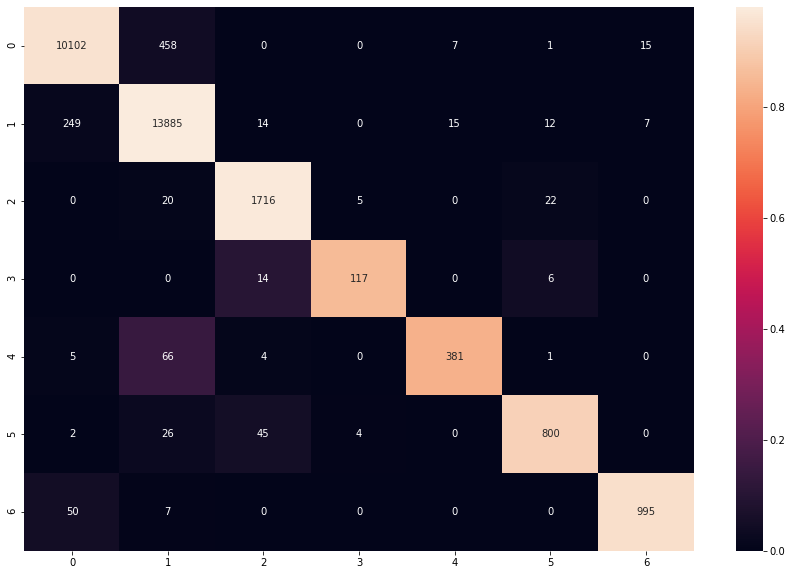

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output

fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(actuals,predictions)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='')
plt.show()

In [63]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [64]:
precision_recall_fscore_support(actuals,predictions)

(array([0.97059954, 0.96010234, 0.95705521, 0.92857143, 0.94540943,
        0.95011876, 0.97836775]),
 array([0.95454975, 0.97905796, 0.9733409 , 0.8540146 , 0.83369803,
        0.91220068, 0.94581749]),
 array([0.96250774, 0.9694875 , 0.96512936, 0.88973384, 0.88604651,
        0.93077371, 0.9618173 ]),
 array([10583, 14182,  1763,   137,   457,   877,  1052]))

In [66]:
print(classification_report(actuals,predictions))

              precision    recall  f1-score   support

           1       0.97      0.95      0.96     10583
           2       0.96      0.98      0.97     14182
           3       0.96      0.97      0.97      1763
           4       0.93      0.85      0.89       137
           5       0.95      0.83      0.89       457
           6       0.95      0.91      0.93       877
           7       0.98      0.95      0.96      1052

    accuracy                           0.96     29051
   macro avg       0.96      0.92      0.94     29051
weighted avg       0.96      0.96      0.96     29051



# Clean Up

In [ ]:
# Uncomment to delete
sm.delete_endpoint(EndpointName=ep_name)

# References

* This dataset is part of the UCI Machine Learning Repository, and the original source can be found [here](https://archive.ics.uci.edu/ml/datasets/covertype). The original database owners are Jock A. Blackard, Dr. Denis J. Dean, and Dr. Charles W. Anderson of the Remote Sensing and GIS Program at Colorado State University.  
* https://gitlab.com/juliensimon/aim307